In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.3

     |████████████████████████████████| 3.2MB 4.6MB/s 
     |████████████████████████████████| 634kB 31.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.3-cp36-none-any.whl size=60764 sha256=e4c23a6765f0c85da45d57601346e1e7b6b9e1ee1943df7f105e6b1478f6b09a
  Stored in directory: /root/.cache/pip/wheels/20/16/8e/d3bec34bf30adff30929226f0b83cc8c005b5af131f51db9d0
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=55d5a71deaa7a9d84cbe70d9f6dac4120a5cbe4454a8a28ed6ba8a4f6cc94bd5
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
from __future__ import print_function, division, absolute_import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import os
import cv2

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
import math
import torch.utils.model_zoo as model_zoo

from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform

from albumentations import (
    PadIfNeeded,
    GaussianBlur,
    Flip,
    HorizontalFlip,
    Transpose,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    Rotate,
    RandomBrightnessContrast,    
    RandomGamma,
    ShiftScaleRotate ,
    GaussNoise,
    Blur,
    MotionBlur
)
my_size = 128

In [0]:
class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        image[ymin:ymax, xmin:xmax] = self.mask_color
        return image


class DualCutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.cutout = Cutout(mask_size, p, cutout_inside, mask_color)

    def __call__(self, image):
        return np.hstack([self.cutout(image), self.cutout(image)])


class DualCutoutCriterion:
    def __init__(self, alpha):
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss(reduction='mean')

    def __call__(self, preds, targets):
        preds1, preds2 = preds
        return (self.criterion(preds1, targets) + self.criterion(
            preds2, targets)) * 0.5 + self.alpha * F.mse_loss(preds1, preds2)


def mixup(data, targets, alpha, n_classes):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = (targets, shuffled_targets, lam)

    return data, targets


def mixup_criterion(preds, targets):
    targets1, targets2, lam = targets
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds, targets1) + (1 - lam) * criterion(
        preds, targets2)
    


class RandomErasing:
    def __init__(self, p, area_ratio_range, min_aspect_ratio, max_attempt):
        self.p = p
        self.max_attempt = max_attempt
        self.sl, self.sh = area_ratio_range
        self.rl, self.rh = min_aspect_ratio, 1. / min_aspect_ratio

    def __call__(self, image):
        image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]
        image_area = h * w

        for _ in range(self.max_attempt):
            mask_area = np.random.uniform(self.sl, self.sh) * image_area
            aspect_ratio = np.random.uniform(self.rl, self.rh)
            mask_h = int(np.sqrt(mask_area * aspect_ratio))
            mask_w = int(np.sqrt(mask_area / aspect_ratio))

            if mask_w < w and mask_h < h:
                x0 = np.random.randint(0, w - mask_w)
                y0 = np.random.randint(0, h - mask_h)
                x1 = x0 + mask_w
                y1 = y0 + mask_h
                image[y0:y1, x0:x1] = np.random.uniform(0, 1)
                break
        return image  

In [0]:
train_aug = Compose([ 
    ShiftScaleRotate(p=1,border_mode=cv2.BORDER_CONSTANT,value =1),
    OneOf([
        GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT,value =1, p=0.1),
        OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT,value =1)                  
        ], p=0.3),
    OneOf([
        Blur(),
        GaussianBlur(blur_limit=3)
        ], p=0.4),    
    RandomGamma(p=0.5)])

In [0]:
class ToTensor:
    def __call__(self, data):
        if isinstance(data, tuple):
            return tuple([self._to_tensor(image) for image in data])
        else:
            return self._to_tensor(data)

    def _to_tensor(self, data):
        if len(data.shape) == 3:
            return torch.from_numpy(data.transpose(2, 0, 1).astype(np.float32))
        else:
            return torch.from_numpy(data[None, :, :].astype(np.float32))


class Normalize:
    def __init__(self, mean, std):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):
        image = np.asarray(image).astype(np.float32) / 255.
        image = (image - self.mean) / self.std
        return image

In [0]:
class Selayer(nn.Module):

    def __init__(self, inplanes):
        super(Selayer, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(inplanes, int(inplanes / 16), kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(int(inplanes / 16), inplanes, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        out = self.global_avgpool(x)

        out = self.conv1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.sigmoid(out)

        return x * out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, cardinality, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)

        self.conv2 = nn.Conv2d(planes * 2, planes * 2, kernel_size=3, stride=stride,
                               padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 2)

        self.conv3 = nn.Conv2d(planes * 2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)

        self.selayer = Selayer(planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.selayer(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SeResNeXt(nn.Module):

    def __init__(self, block, layers, cardinality=32, num_classes=1000):
        super(SeResNeXt, self).__init__()
        self.cardinality = cardinality
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.cardinality))
                             
        # vowel_diacritic
        self.fc1 = nn.Linear(2048,11)
        # grapheme_root
        self.fc2 = nn.Linear(2048,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(2048,7)
        return nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        
        return x1,x2,x3


def se_resnext50(**kwargs):
    """Constructs a SeResNeXt-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def se_resnext101(**kwargs):
    """Constructs a SeResNeXt-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def se_resnext152(**kwargs):
    """Constructs a SeResNeXt-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

In [0]:
train = pd.read_csv('/content/drive/My Drive/nipuyo/train.csv')
data0 = pd.read_feather('/content/drive/My Drive/black_128/train_data_00_l.feather')
data1 = pd.read_feather('/content/drive/My Drive/black_128/train_data_11_l.feather')
data2 = pd.read_feather('/content/drive/My Drive/black_128/train_data_22_l.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black_128/train_data_33_l.feather')

In [0]:
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)
del data0,data1,data2,data3

In [0]:
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train',transform =True,aug = train_aug):
        self.df = df
        self.label = label
        self.aug = aug
        self.transform = transform
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.data[idx, :].reshape(my_size,my_size).astype(np.float)
        if self.transform: 
            #out = np.empty((my_size, my_size, 3), dtype=np.uint8)#converting to 3channel image
            #out[:, :, 0] = image
            #out[:, :, 1] = image
            #out[:, :, 2] = image
            #print(image.shape)
            augment = self.aug(image = image)
            image = augment['image']
            cutout = Cutout(10,0.3,True,1)
            image = cutout(image)
        #norm = Normalize([0.0692],[0.2051])
        #image = norm(image)
        return image,label1,label2,label3

In [0]:
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train,test_size=0.20, random_state=42,shuffle=True) ## Split Labels
data_train_df, data_valid_df = train_test_split(data_full,test_size=0.20, random_state=42,shuffle =True) ## split data

In [12]:
import gc
gc.collect()

305

In [13]:
train_dataset = GraphemeDataset(data_train_df ,train_df,transform = True) 
valid_dataset = GraphemeDataset(data_valid_df ,valid_df,transform = False) 
torch.cuda.empty_cache()
gc.collect()

0

In [0]:
import matplotlib.pyplot as plt
def visualize(original_image,aug_image):
    fontsize = 18
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image,cmap='gray')
    ax[1].set_title('Augmented image', fontsize=fontsize)

In [0]:
orig_image = data_train_df.iloc[0, 1:].values.reshape(128,128).astype(np.float)
aug_image = train_dataset[0][0]

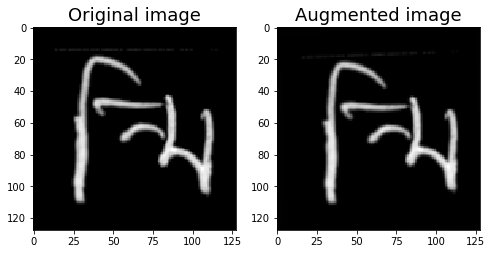

In [16]:
for i in range (1):
    aug_image = train_dataset[0][0]
    visualize (orig_image,aug_image)

In [17]:
del train_df,valid_df,data_train_df,data_valid_df 
torch.cuda.empty_cache()
gc.collect()

4673

In [0]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = se_resnext50().to(device)

cuda:0


In [0]:
optimizer =torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 2e-4)
#criterion = nn.CrossEntropyLoss()
batch_size=32

In [0]:
def ohem_loss( rate, cls_pred, cls_target ):

    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets
# loss 
def cutmix_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    lo1 = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)
    lo2 = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
    lo3 = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
    return lo1,lo2,lo3


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    lo1 = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)
    lo2 = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
    lo3 = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
    return  lo1,lo2,lo3 
    #return [ lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2), lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4), lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]

In [0]:
import numpy
def train(epoch):
  model.train()
  losses = []
  accs = []
  acc= 0.0
  total = 0.0
  running_loss = 0.0
  running_acc = 0.0
  val_now_acc = 0.0
  for idx, (inputs,labels1,labels2,labels3) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels1 = labels1.to(device)
      labels2 = labels2.to(device)
      labels3 = labels3.to(device)
      total += len(inputs)
      optimizer.zero_grad()
      inputs, targets = mixup(inputs, labels1, labels2, labels3, 0.4)
      outputs1, outputs2, outputs3 = model(inputs.unsqueeze(1).float())
      loss1,loss2,loss3 = mixup_criterion(outputs1,outputs2,outputs3, targets) 

      running_loss += loss1.item()+loss2.item()+loss3.item()
      running_acc += (outputs1.argmax(1)==labels1).float().mean()
      running_acc += (outputs2.argmax(1)==labels2).float().mean()
      running_acc += (outputs3.argmax(1)==labels3).float().mean()
      (loss1+loss2+loss3).backward()
      optimizer.step()
      acc = running_acc/total
      #scheduler.step()
  
  losses.append(running_loss/len(train_loader))
  accs.append(running_acc/(len(train_loader)*3))
  print(' train epoch : {}\tacc : {:.2f}%'.format(epoch,running_acc/(len(train_loader)*3)))
  print('loss : {:.4f}'.format(running_loss/len(train_loader)))
  torch.save(model.state_dict(), 'resnext.pth') ## Saving model weights
  torch.cuda.empty_cache()
  gc.collect()
  return losses , accs
    
def evaluate(epoch):
   model.eval()
   losses = []
   accs = []
   acc= 0.0
   total = 0.0
   #print('epochs {}/{} '.format(epoch+1,epochs))
   running_loss = 0.0
   running_acc = 0.0
   with torch.no_grad():
     for idx, (inputs,labels1,labels2,labels3) in enumerate(valid_loader):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        total += len(inputs)
        inputs, targets = mixup(inputs, labels1, labels2, labels3, 0.4)
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1_val,loss2_val,loss3_val = mixup_criterion(outputs1,outputs2,outputs3, targets)  

        running_loss += loss1_val.item()+loss2_val.item()+loss3_val.item()
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
      
        acc = running_acc/total
        #scheduler.step()
         
   losses.append(running_loss/len(valid_loader))
   accs.append(running_acc/(len(valid_loader)*3))
   print('val epoch: {} \tval acc : {:.2f}%'.format(epoch,running_acc/(len(valid_loader)*3)))
   print('loss : {:.4f}'.format(running_loss/len(valid_loader)))
   val_acc_now = running_acc/(len(valid_loader)*3)
   return losses , accs , val_acc_now

In [0]:
%%time
n_epochs = 5
best_val_acc = 0.0
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    tain_losses,train_accs = train(epoch)
    valid_losses,valid_accs,val_acc_now = evaluate(epoch)
    if val_acc_now > best_val_acc:
      print(f'Validation accuracy has increased from:  {best_val_acc:.4f} to: {val_acc_now:.4f}. Saving checkpoint')
      #torch.save(model.state_dict(), '/content/drive/My Drive/black_128/se_resnext101.pth')
      best_val_acc = val_acc_now

 train epoch : 0	acc : 0.57%
loss : 2.6576
val epoch: 0 	val acc : 0.58%
loss : 2.4926
Validation accuracy has increased from:  0.0000 to: 0.5763. Saving checkpoint


In [0]:
history.to_csv('history.csv')
history.head()

In [0]:
# Any results you write to the current directory are saved as output.
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

In [0]:
test = pd.read_csv('/content/drive/My Drive/begali comp/bengaliai-cv19/test.csv')

In [0]:
class GraphemeDataset(Dataset):
    def __init__(self,df,_type='train'):
        self.df = df
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        name = self.df.iloc[idx,0]
        #image = self.df.iloc[idx][1:].values.reshape(128,128).astype(float)
        image = self.data[idx, :].reshape(128,128).astype(np.float)
        return image,name

In [0]:
test_data = ['test_image_data_0.parquet','test_image_data_1.parquet','test_image_data_2.parquet','test_image_data_3.parquet']

In [0]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

def Resize(df,size=128):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
       # image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        image0 = 255 - df.loc[df.index[i]].values.reshape(137,236).astype(np.uint8)
    #normalize each image by its max val
        img = (image0*(255.0/image0.max())).astype(np.uint8)
        image = crop_resize(img)
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [0]:
%%time
## Inference a little faster using @Iafoss and  @peters technique
row_id,target = [],[]
for fname in test_data:
    data = pd.read_parquet(f'/content/drive/My Drive/begali comp/bengaliai-cv19/{fname}')
    data = Resize(data)
    test_image = GraphemeDataset(data)
    dl = torch.utils.data.DataLoader(test_image,batch_size=128,num_workers=4,shuffle=False)
    with torch.no_grad():
        for x,y in tqdm(dl):
            x = x.unsqueeze(1).float().cuda()
            p1,p2,p3 = model(x)
            p1 = p1.argmax(-1).view(-1).cpu()
            p2 = p2.argmax(-1).view(-1).cpu()
            p3 = p3.argmax(-1).view(-1).cpu()
            for idx,name in enumerate(y):
                row_id += [f'{name}_vowel_diacritic',f'{name}_grapheme_root',
                           f'{name}_consonant_diacritic']
                target += [p1[idx].item(),p2[idx].item(),p3[idx].item()]
                
sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv('submission.csv', index=False)
sub_df

In [0]:
sub_df